<a href="https://colab.research.google.com/github/madhumitadange/Generate-Source-Galaxy-Images-from-Strong-Gravitational-Lens-Images/blob/main/CS230StrongGravitatialLensingPart1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strong Gravitatial Lensing : Lense parameter predictions using Deep CNNs
Part 1




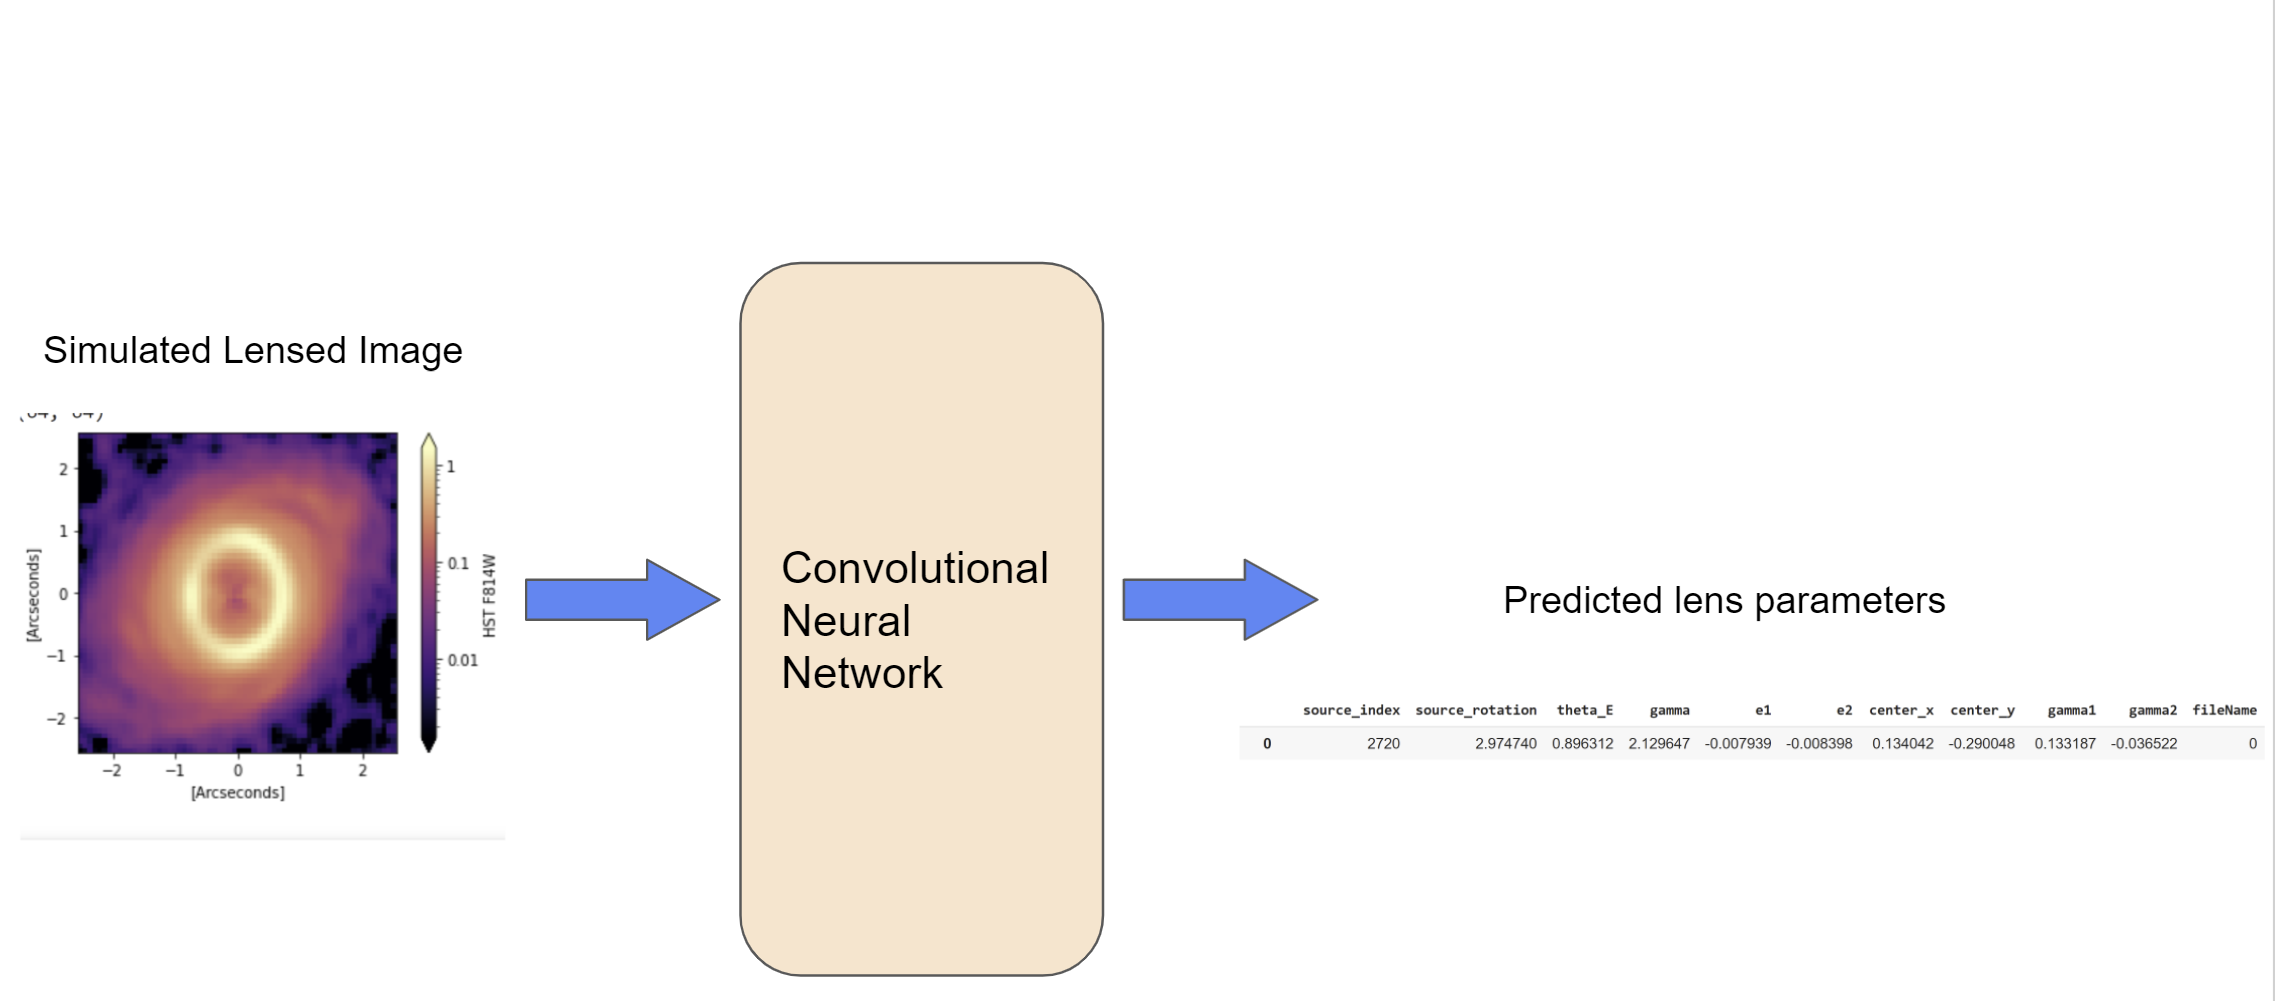

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tqdm import tqdm
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

Read Data created by lenstronamy. Details about Preproccessing, data augmentation, test train, dev split etc in another Notebook 

In [ ]:

zip_ref = zipfile.ZipFile("/content/drive/My Drive/CS230/ProjectData.zip", 'r')
zip_ref.extractall("/CS230")
zip_ref.close()

#Helper Function to plot Lensed and Unlensed images
Ref: https://github.com/JelleAalbers/minilensmaker/tree/main/minilensmaker

In [ ]:
def exporter():
    """Export utility modified from https://stackoverflow.com/a/41895194
    Returns export decorator, __all__ list
    """
    all_ = []

    def decorator(obj):
        all_.append(obj.__name__)
        return obj

    return decorator, all_


export, __all__ = exporter()
__all__.append("exporter")


@export
def image_grid(
    shape,
    pixel_width,
    x0=0,
    y0=0,
    edges=True,
):
    nx, ny = shape
    dx = nx * pixel_width
    dy = nx * pixel_width
    extra = 1 if edges else 0
    x = np.linspace(-dx / 2, dx / 2, nx + extra) + x0
    y = np.linspace(-dy / 2, dy / 2, ny + extra) + y0
    return x, y


@export
def plot_image(
    img,
    pixel_width,
    log_scale=True,
    label="HST F814W",
    colorbar=True,
    adjust_ax=True,
    vmin=None,
    vmax=None,
    **kwargs
):

    # Set reasonable defaults
    if vmax is None:
        vmax = img.max()
    if vmin is None:
        if log_scale:
            vmin = vmax * 1e-3
        else:
            vmin = img.min()
    kwargs.setdefault(
        "norm",
        matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
        if log_scale
        else matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),
    )
    kwargs.setdefault("cmap", "magma")

    # Plot image, note transposition
    plt.pcolormesh(
        *image_grid(img.shape, pixel_width), img.clip(vmin, None).T, **kwargs
    )
    if adjust_ax:
        plt.gca().set_aspect("equal")

    if colorbar:
        # Plot colorbar
        cbar = plt.colorbar(label=label, extend="both")
        cax = cbar.ax
        # Format colobar ticks as scalars (not 10^x)
        cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%g"))
        if len(cbar.get_ticks()) < 2:
            # If there are very few colorbar ticks, show minor ticks too
            cax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%g"))
            cax.tick_params(axis="y", labelsize=7, which="minor")

    plt.xlabel("[Arcseconds]")
    plt.ylabel("[Arcseconds]")


@export
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    plt.gca().add_patch(
        matplotlib.patches.Rectangle(
            (x[0], y[0]), x[1] - x[0], y[1] - y[0], facecolor="none", **kwargs
        )
    )#

In [ ]:
!ls /CS230/ProjectData/test

Lensed	Unlensed


In [ ]:
datafile = np.load("/CS230/ProjectData/train/Lensed/24178.npy")
np.amax(datafile)

1.5125014509087362

Visualized Gravitatinal lensing image

(64, 64)


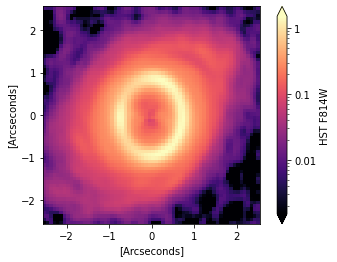

In [ ]:
plot_image(datafile,pixel_width=0.08)
print(datafile.shape)

Visualization of Training data 

/CS230/ProjectData/train/Lensed/19086.npy
20211


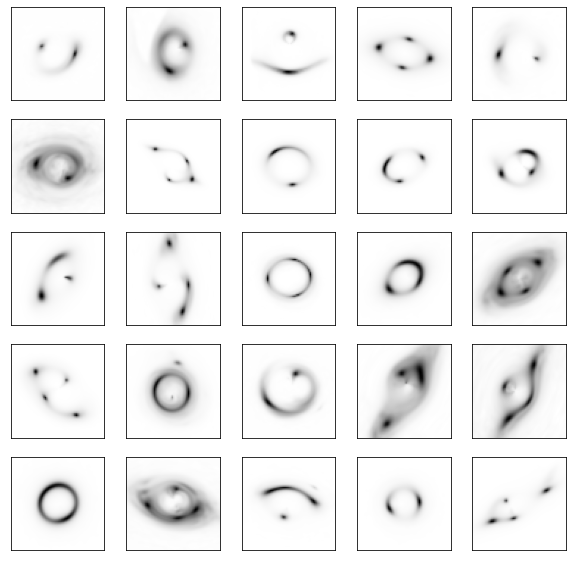

In [ ]:
train_url = "/CS230//ProjectData/train/Lensed"

import pathlib

data = pathlib.Path('ProjectData.zip', train_url)
train_images = list(data.glob('*.npy'))

print(train_images[0])
print(len(train_images))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = np.load(train_images[i]) / 255
    plt.imshow(img, cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    #plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Read Train Images and Train labels. Output layer is 8 continuous parameters 

In [ ]:
trainPara = pd.read_csv("/CS230/ProjectData/trainParameters.csv")
print(trainPara["source_rotation"].dtype)
#display(trainPara)
print(trainPara.columns)
trainFeatureName = trainPara["fileName"]
# train_images #/CS230/ProjectData/train/Lensed/52730_5.720406822933091.npy

trainImage = []
for i in tqdm(range(trainPara.shape[0])):
  try:
    img = np.load("/CS230/ProjectData/train/Lensed/"+trainPara['fileName'][i].astype(str)+'.npy')
    trainImage.append(img)
  except:
    #continue
    print("/CS230/ProjectData/train/Lensed/"+trainPara['fileName'][i].astype(str))

xTrain = np.array(trainImage)
print(xTrain.shape)

trainLabels = trainPara[['theta_E', 'gamma', 'e1', 'e2','center_x', 'center_y', 'gamma1', 'gamma2']]
##print(trainLabels.head())
#print(trainFeatureName.head())


  1%|▏         | 254/20211 [00:00<00:07, 2538.89it/s]

float64
Index(['source_index', 'source_rotation', 'theta_E', 'gamma', 'e1', 'e2',
       'center_x', 'center_y', 'gamma1', 'gamma2', 'fileName'],
      dtype='object')


100%|██████████| 20211/20211 [00:07<00:00, 2558.41it/s]


(20211, 64, 64)


In [ ]:
display(trainPara)

,source_index,source_rotation,theta_E,gamma,e1,e2,center_x,center_y,gamma1,gamma2,fileName
0,2720,2.974740,0.896312,2.129647,-0.007939,-0.008398,0.134042,-0.290048,0.133187,-0.036522,0
1,34461,3.235396,1.198289,2.026151,-0.045114,-0.019775,-0.086834,-0.272532,-0.019896,0.132149,1
2,46666,5.749283,0.989821,1.933094,0.027792,-0.013456,-0.012319,-0.286107,-0.074430,-0.264630,2
3,2309,0.832937,0.819008,2.244781,0.039451,-0.029669,0.208221,0.012079,0.065658,-0.010765,4
4,20627,4.150509,0.958982,1.935049,0.023052,0.028455,-0.018407,-0.243672,0.013548,0.096941,5
...,...,...,...,...,...,...,...,...,...,...,...
20206,8085,4.917573,0.881434,2.104400,-0.034017,0.044727,0.071738,-0.278314,-0.249222,-0.328943,24175
20207,11907,0.002730,1.158542,1.806199,-0.047069,0.000530,-0.292097,0.270716,-0.154953,0.050621,24176
20208,25835,3.718188,0.993682,1.902162,-0.014586,-0.025752,-0.402983,-0.199935,0.115692,0.021702,24177
20209,29176,4.100282,0.807907,2.030633,0.004522,-0.019899,-0.042271,-0.052721,0.112085,-0.001210,24178


Read Dev Images and Dev labels.

In [ ]:
devPara = pd.read_csv("/CS230/ProjectData/devParameters.csv")
devImage = []
for i in tqdm(range(devPara.shape[0])):
  try:
    img = np.load("/CS230/ProjectData/dev/Lensed/"+devPara['fileName'][i].astype(str)+'.npy')
    devImage.append(img)
  except:
    #continue
    print("/CS230/ProjectData/dev/Lensed/"+devPara['fileName'][i].astype(str))

xDev = np.array(devImage)
print(xDev.shape)

devLabels = devPara[['theta_E', 'gamma', 'e1', 'e2','center_x', 'center_y', 'gamma1', 'gamma2']]
print(devLabels.head())


100%|██████████| 1977/1977 [00:00<00:00, 2380.55it/s]

(1977, 64, 64)
    theta_E     gamma        e1  ...  center_y    gamma1    gamma2
0  0.914416  1.987249  0.018528  ...  0.141636  0.012631 -0.162176
1  0.840961  2.119192  0.049718  ... -0.111273  0.072817  0.201619
2  0.816109  2.125329  0.020502  ... -0.214955  0.031925 -0.080434
3  0.899451  1.960817  0.028842  ... -0.041510 -0.119172 -0.071634
4  0.851271  1.991514  0.030728  ... -0.354111  0.275506  0.067538

[5 rows x 8 columns]


Read Test Images and Test labels.

In [ ]:
testPara = pd.read_csv("/CS230/ProjectData/testParameters.csv")
testImage = []
for i in tqdm(range(testPara.shape[0])):
  try:
    img = np.load("/CS230/ProjectData/test/Lensed/"+testPara['fileName'][i].astype(str)+'.npy')
    testImage.append(img)
  except:
    #continue
    print("/CS230/ProjectData/test/Lensed/"+testPara['fileName'][i].astype(str))

xTest = np.array(testImage)
print(xTest.shape)

testLabels = testPara[['theta_E', 'gamma', 'e1', 'e2','center_x', 'center_y', 'gamma1', 'gamma2']]
print(testLabels.head())

100%|██████████| 1992/1992 [00:00<00:00, 2563.86it/s]

(1992, 64, 64)
    theta_E     gamma        e1  ...  center_y    gamma1    gamma2
0  0.988996  1.979358 -0.010125  ... -0.061619  0.099844 -0.119436
1  0.899884  2.129039 -0.042981  ...  0.120822 -0.131954 -0.152080
2  0.812406  1.976866 -0.041048  ...  0.063908  0.046120 -0.001831
3  1.185563  2.061452 -0.007189  ... -0.142974 -0.129649 -0.133738
4  1.011696  1.881454  0.003310  ...  0.028639  0.128727 -0.302465

[5 rows x 8 columns]


Create the model


> The model consists of three convolution blocks with a max pool layer in each of them.Last layer is output layer for 8 parameters, We used regression



In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),input_shape=(64, 64, 1),use_bias=False))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Conv2D(64, (3, 3) ,use_bias=False))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Conv2D(64, (3, 3),use_bias=False))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8,activation='linear'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        288       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18432     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        2

Reshape data 

In [ ]:
x_train = xTrain.reshape(-1,64, 64, 1)
x_dev = xDev.reshape(-1, 64, 64, 1)
x_test = xTest.reshape(-1, 64, 64, 1)

Compile and train the model

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])

history = model.fit(x_train, trainLabels,batch_size=32, epochs=5, validation_data=(x_dev, devLabels))

Epoch 1/5
632/632 [==============================] - 37s 7ms/step - loss: 0.1176 - mse: 0.1176 - mae: 0.1909 - mape: 1046.0649 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1160 - val_mape: 1410.8318
Epoch 2/5
632/632 [==============================] - 4s 6ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0913 - mape: 482.8488 - val_loss: 0.0110 - val_mse: 0.0110 - val_mae: 0.0756 - val_mape: 1625.3285
Epoch 3/5
632/632 [==============================] - 4s 6ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0752 - mape: 333.3202 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0632 - val_mape: 419.8940
Epoch 4/5
632/632 [==============================] - 4s 6ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0628 - mape: 271.6223 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0559 - val_mape: 1130.2780
Epoch 5/5
632/632 [==============================] - 4s 6ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0530 - mape: 276.8640 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0489 - val_mape:

Visualize training results
Create plots of loss and accuracy on the training and validation sets.

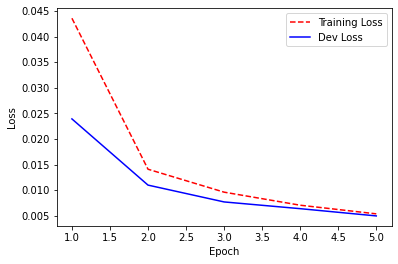

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
dev_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, dev_loss, 'b-')
plt.legend(['Training Loss', 'Dev Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

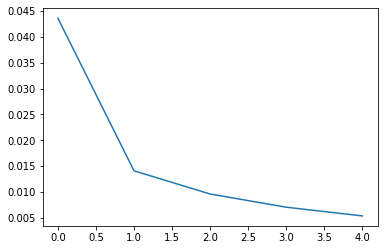

In [ ]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history.history['mse'])

pyplot.show()

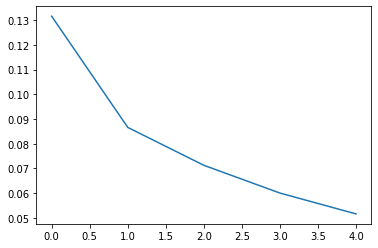

In [ ]:
pyplot.plot(history.history['mae'])
pyplot.show()

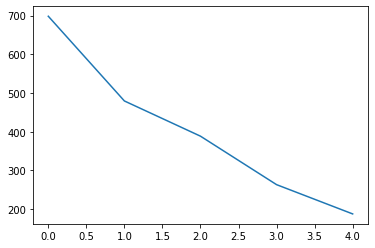

In [ ]:
pyplot.plot(history.history['mape'])
pyplot.show()

In [ ]:
test_results = model.predict(x_test)

In [ ]:
test_results_eval = model.evaluate(x_test, testLabels, verbose=0)

In [ ]:
testout = pd.DataFrame(model.predict(x_test))

In [ ]:
testout.columns = ['theta_E_out', 'gamma_out', 'e1_out', 'e2_out','center_x_out', 'center_y_out', 'gamma1_out', 'gamma2_out']
display(testout)

,theta_E_out,gamma_out,e1_out,e2_out,center_x_out,center_y_out,gamma1_out,gamma2_out
0,0.990327,1.939990,-0.015480,-0.009140,0.230192,0.053327,0.023714,-0.147161
1,0.892304,1.947618,0.001224,-0.001157,-0.054385,0.045245,-0.121575,-0.131016
2,0.825173,1.944839,-0.005506,-0.005073,0.134915,0.047252,0.022845,-0.004892
3,1.148068,1.972516,0.001556,-0.004045,0.181919,-0.085194,-0.141787,-0.156034
4,0.999084,1.880460,0.000814,0.001642,0.253650,0.075425,0.145430,-0.315012
...,...,...,...,...,...,...,...,...
1987,1.074931,2.001791,-0.003903,-0.003029,-0.018005,0.153992,0.240418,0.006509
1988,0.928144,1.898821,-0.000244,-0.001843,-0.033036,-0.109884,-0.051880,-0.088377
1989,0.865214,1.925497,0.005460,-0.003651,0.245633,0.059147,-0.317144,0.063577
1990,1.112813,1.952715,-0.001893,-0.000655,0.193245,0.114663,0.262995,-0.208698


Analyze test results per output class 

In [ ]:
from sklearn.metrics import mean_squared_error
index =range(1,2)
columns= ['theta_E', 'gamma', 'e1', 'e2','center_x', 'center_y', 'gamma1', 'gamma2']
rms =pd.DataFrame(index=index,columns=columns)
# Compute the root-mean-square
rms["theta_E"] = np.sqrt(mean_squared_error(testLabels["theta_E"], testout["theta_E_out"]))
rms["gamma"] = np.sqrt(mean_squared_error(testLabels["gamma"], testout["gamma_out"]))
rms["e1"] = np.sqrt(mean_squared_error(testLabels["e1"], testout["e1_out"]))
rms["e2"] = np.sqrt(mean_squared_error(testLabels["e2"], testout["e2_out"]))
rms["center_x"] = np.sqrt(mean_squared_error(testLabels["center_x"], testout["center_x_out"]))
rms["center_y"] = np.sqrt(mean_squared_error(testLabels["center_y"], testout["center_y_out"]))
rms["gamma1"] = np.sqrt(mean_squared_error(testLabels["gamma1"], testout["gamma1_out"]))
rms["gamma2"] = np.sqrt(mean_squared_error(testLabels["gamma2"], testout["gamma2_out"]))


display(rms)

,theta_E,gamma,e1,e2,center_x,center_y,gamma1,gamma2
1,0.055543,0.101379,0.029151,0.029252,0.099835,0.094669,0.058229,0.052622


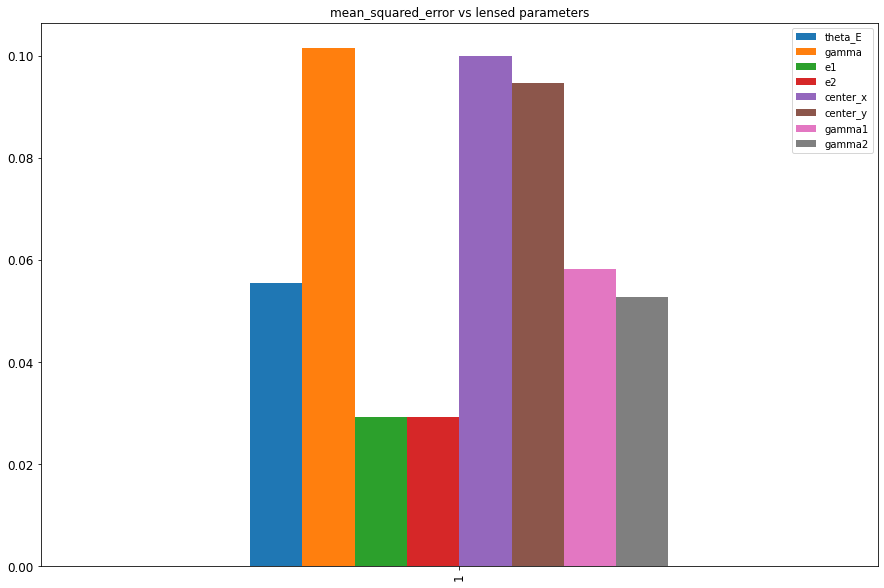

In [ ]:
rms.plot(kind='bar', title ="mean_squared_error vs lensed parameters", figsize=(15, 10), legend=True, fontsize=12)

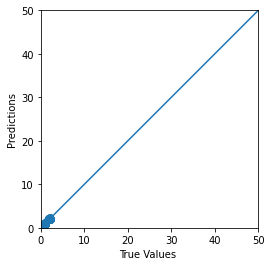

In [ ]:
test_predictions = model.predict(x_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(testLabels.to_numpy().flatten(), test_predictions)
plt.xlabel('True Values ')
plt.ylabel('Predictions')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
test_predictions.size/8

1992.0

In [ ]:
 pd.DataFrame(testLabels)

,theta_E,gamma,e1,e2,center_x,center_y,gamma1,gamma2
0,0.988996,1.979358,-0.010125,-0.002919,0.674781,-0.061619,0.099844,-0.119436
1,0.899884,2.129039,-0.042981,0.037794,-0.081160,0.120822,-0.131954,-0.152080
2,0.812406,1.976866,-0.041048,0.016297,0.163132,0.063908,0.046120,-0.001831
3,1.185563,2.061452,-0.007189,0.022357,0.083089,-0.142974,-0.129649,-0.133738
4,1.011696,1.881454,0.003310,0.002711,0.221541,0.028639,0.128727,-0.302465
...,...,...,...,...,...,...,...,...
1987,1.156553,1.987343,0.011412,0.012531,-0.212949,0.260928,0.381321,0.101194
1988,0.920798,1.909368,-0.020103,0.042903,-0.019513,-0.220293,-0.073207,-0.000534
1989,0.868316,2.090636,-0.009206,-0.041858,0.248114,0.121524,-0.343079,0.060398
1990,1.037076,2.082383,0.030921,0.035479,0.199733,0.057502,0.318420,-0.295645


In [ ]:
 pd.DataFrame(test_results)

,0,1,2,3,4,5,6,7
0,0.990327,1.939990,-0.015480,-0.009140,0.230192,0.053327,0.023714,-0.147161
1,0.892304,1.947618,0.001224,-0.001157,-0.054385,0.045245,-0.121575,-0.131016
2,0.825173,1.944839,-0.005506,-0.005073,0.134915,0.047252,0.022845,-0.004892
3,1.148068,1.972516,0.001556,-0.004045,0.181919,-0.085194,-0.141787,-0.156034
4,0.999084,1.880460,0.000814,0.001642,0.253650,0.075425,0.145430,-0.315012
...,...,...,...,...,...,...,...,...
1987,1.074931,2.001791,-0.003903,-0.003029,-0.018005,0.153992,0.240418,0.006509
1988,0.928144,1.898821,-0.000244,-0.001843,-0.033036,-0.109884,-0.051880,-0.088377
1989,0.865214,1.925497,0.005460,-0.003651,0.245633,0.059147,-0.317144,0.063577
1990,1.112813,1.952715,-0.001893,-0.000655,0.193245,0.114663,0.262995,-0.208698
